In [ ]:
!pip install fastai==1.0.42

In [1]:
from fastai import *
from fastai.vision import *
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
torch.cuda.is_available()
torch.backends.cudnn.enabled

True

In [3]:
base_image_dir = '../input/aptos-augmented/aptos/upload/'
df = pd.read_csv('../input/aptos-augmented/aptos.csv')
df.columns = ['image', 'level']
df['path'] = df['image'].map(lambda x: os.path.join(base_image_dir,'{}.png'.format(x)))
df['exists'] = df['path'].map(os.path.exists) #Most of the files do not exist because this is a sample of the original dataset
df = df[df['exists']]
df = df.drop(columns=['image','exists'])
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
df.head(10)

,level,path
0,0,../input/aptos-augmented/aptos/upload/0b3efe66...
1,2,../input/aptos-augmented/aptos/upload/96c3e3db...
2,4,../input/aptos-augmented/aptos/upload/86ba5604...
3,3,../input/aptos-augmented/aptos/upload/f54c8a29...
4,1,../input/aptos-augmented/aptos/upload/1d117940...
5,2,../input/aptos-augmented/aptos/upload/1438288b...
6,3,../input/aptos-augmented/aptos/upload/f5712398...
7,3,../input/aptos-augmented/aptos/upload/edf80a4d...
8,1,../input/aptos-augmented/aptos/upload/7758c883...
9,2,../input/aptos-augmented/aptos/upload/82deb07a...


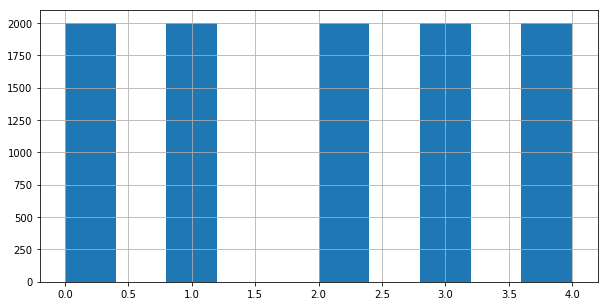

In [4]:
df['level'].hist(figsize = (10, 5))

In [5]:
df.pivot_table(index='level', aggfunc=len)

,path
level,
0,2000
1,2000
2,2000
3,2000
4,2000


In [6]:
def balance_data(class_size,df):
    train_df = df.groupby(['level']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['level'].hist(figsize = (10, 5))
    return train_df

In [7]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df,test_size=0.2) # Here we will perform an 80%/20% split of the dataset, with stratification to keep similar distribution in validation set

2000

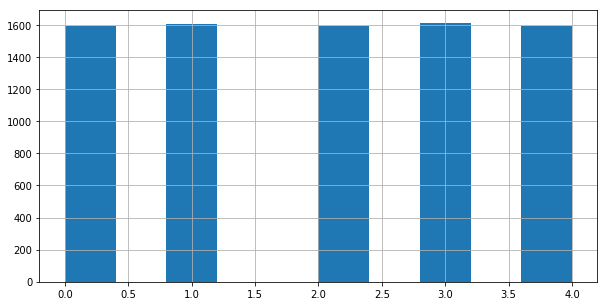

In [8]:
train_df['level'].hist(figsize = (10, 5))
len(val_df)

In [9]:
train_df.pivot_table(index='level', aggfunc=len)

,path
level,
0,1596
1,1608
2,1592
3,1612
4,1592


New Data Size: 8060 Old Size: 8000


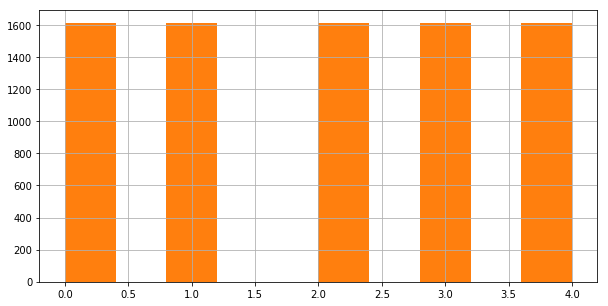

In [10]:
train_df = balance_data(train_df.pivot_table(index='level', aggfunc=len).max().max(),train_df) # I will oversample such that all classes have the same number of images as the maximum
train_df['level'].hist(figsize = (10, 5))

In [11]:
df = pd.concat([train_df,val_df]) #beginning of this dataframe is the oversampled training set, end is the validation set
len(df)

10060

In [12]:
from PIL import Image

im = Image.open(train_df['path'][1])
width, height = im.size
print(width,height) 

300 300


In [13]:
bs = 32 #smaller batch size is better for training, but may take longer
sz=256

In [14]:
tfms = get_transforms(do_flip=True,flip_vert=True,max_rotate=360,max_warp=0,max_zoom=1.1,max_lighting=0.1,p_lighting=0.5)
src = (ImageItemList.from_df(df=df,path='./',cols='path') #get dataset from dataset
        .split_by_idx(range(len(train_df)-1,len(df))) #Splitting the dataset
        .label_from_df(cols='level') #obtain labels from the level column
      )
data= (src.transform(tfms,size=sz) #Data augmentation
        .databunch(bs=bs,num_workers=0) #DataBunch
        .normalize(imagenet_stats) #Normalize
       )

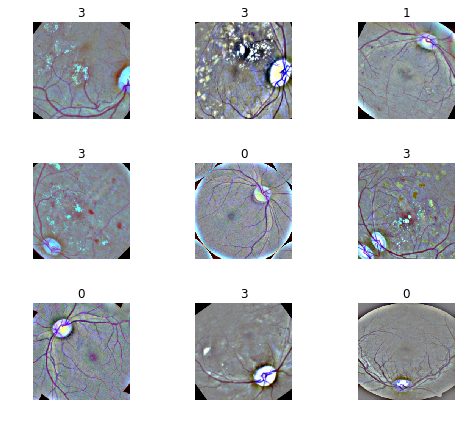

In [15]:
data.show_batch(rows=3, figsize=(7,6))

In [16]:
print(data.classes)
len(data.classes),data.c

[0, 1, 2, 3, 4]


(5, 5)

In [17]:
from sklearn.metrics import cohen_kappa_score
def quadratic_kappa(y_hat, y):
    return torch.tensor(cohen_kappa_score(torch.argmax(y_hat,1), y, weights='quadratic'),device='cuda:0')

In [18]:
import torchvision
learn = create_cnn(data, models.resnet50, metrics = [accuracy,quadratic_kappa])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 100437638.98it/s]


In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.31E-04


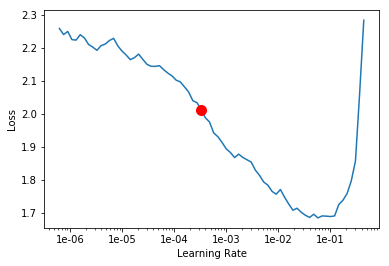

In [20]:
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(8,max_lr = 2e-3)

epoch,train_loss,valid_loss,accuracy,quadratic_kappa
1,0.571439,0.674497,0.732134,0.814730
2,0.569077,0.571610,0.779110,0.860866
3,0.486102,0.498981,0.809095,0.879919
4,0.372487,0.466895,0.810595,0.886263


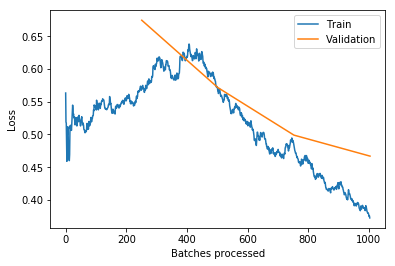

In [23]:
learn.recorder.plot_losses()

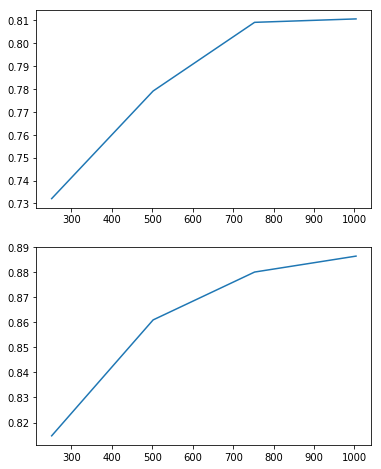

In [24]:
learn.recorder.plot_metrics()

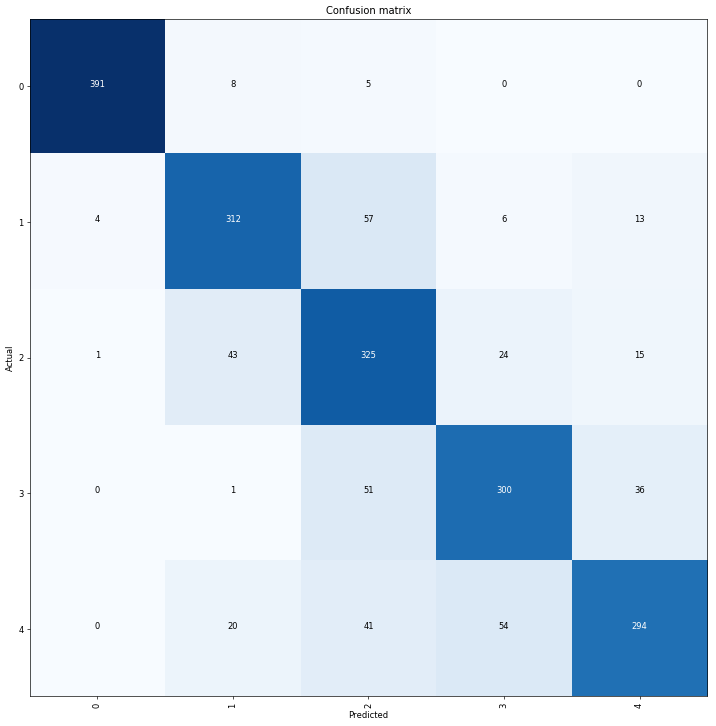

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [26]:
learn.save('stage-1-224')

In [27]:
learn.unfreeze()

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.29E-06


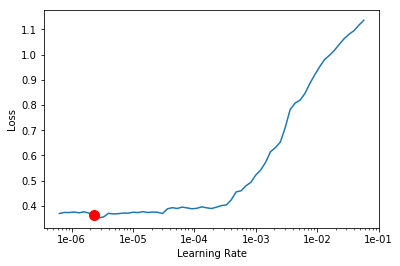

In [29]:
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(8, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,quadratic_kappa
1,0.379178,0.458450,0.816592,0.889060
2,0.389614,0.444961,0.817591,0.889140
3,0.341301,0.404824,0.840080,0.905570
4,0.320580,0.389355,0.848576,0.906824
5,0.285725,0.385004,0.842079,0.909549
6,0.259092,0.366009,0.852074,0.915670
7,0.235370,0.363465,0.856072,0.916133
8,0.243961,0.358013,0.856072,0.917104


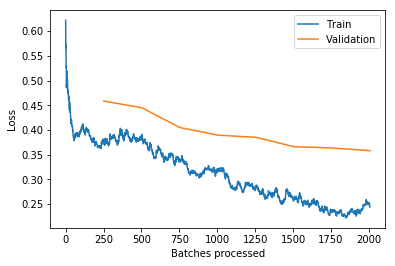

In [31]:
learn.recorder.plot_losses()

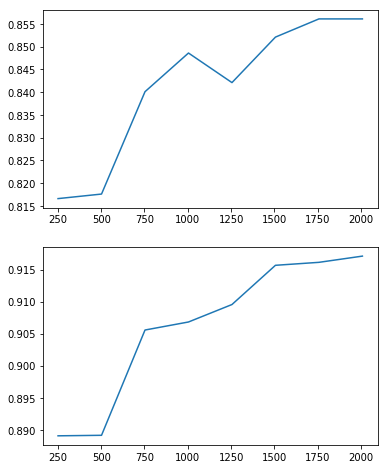

In [32]:
learn.recorder.plot_metrics()

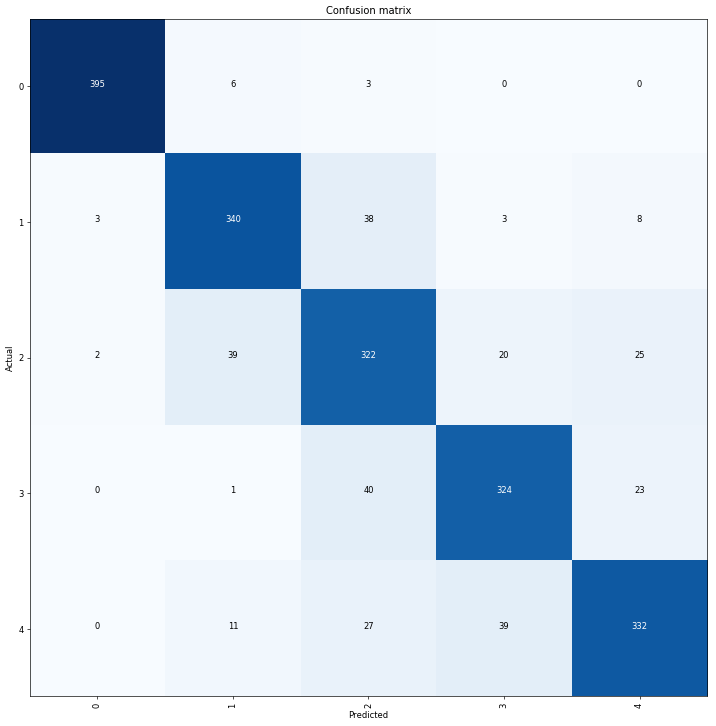

In [33]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [34]:
learn.save('stage-2-224')

In [35]:
data = (src.transform(tfms,size=sz*2) #Data augmentation
        .databunch(bs=bs,num_workers=0) #DataBunch
        .normalize(imagenet_stats) #Normalize
       )

In [36]:
learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 512, 512])

In [37]:
learn.freeze()

In [38]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.32E-06


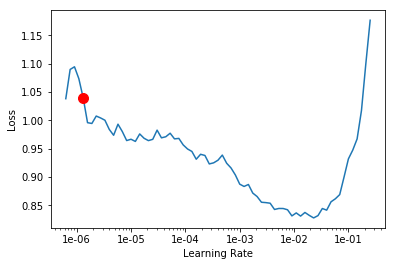

In [39]:
learn.recorder.plot()

In [40]:
learn.fit_one_cycle(8,max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,quadratic_kappa
1,0.567974,0.495339,0.798601,0.877474
2,0.428508,0.458867,0.821589,0.895826
3,0.363286,0.402751,0.845077,0.900373
4,0.330671,0.371765,0.857071,0.908992
5,0.269893,0.353551,0.868566,0.923661
6,0.229466,0.314398,0.881559,0.936372
7,0.209358,0.298120,0.889055,0.937920
8,0.193225,0.305944,0.877061,0.931451


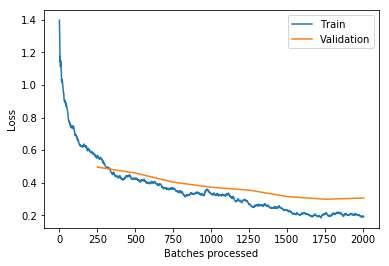

In [41]:
learn.recorder.plot_losses()

In [43]:
learn.recorder.plot_metrics()

AssertionError: There are no metrics to plot.

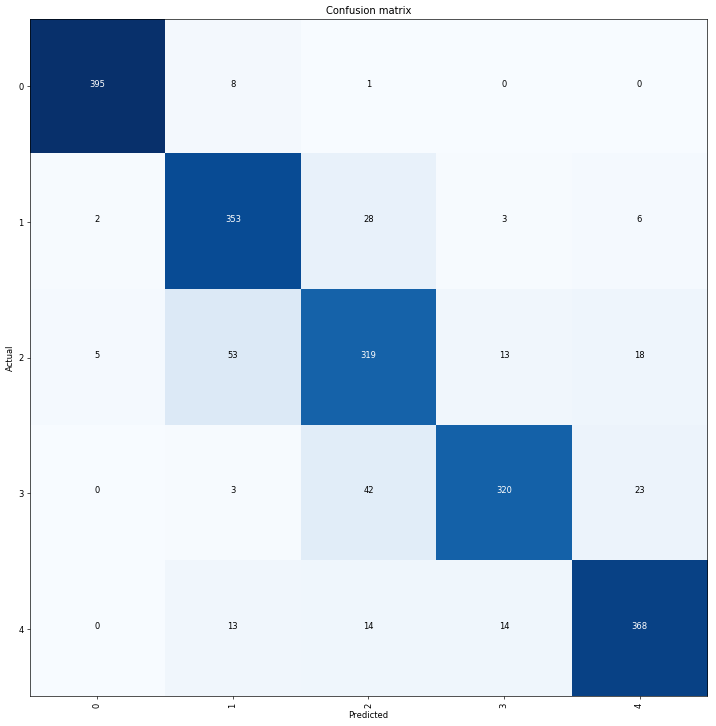

In [44]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [45]:
learn.save('stage-1-448')

In [46]:
learn.unfreeze()

In [47]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


ValueError: Shape of array too small to calculate a numerical gradient, at least (edge_order + 1) elements are required.

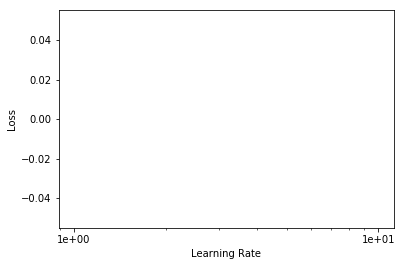

In [48]:
learn.recorder.plot()

In [49]:
learn.fit_one_cycle(8,max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,quadratic_kappa
1,0.198039,0.292073,0.892054,0.940082
2,0.198898,0.312214,0.885557,0.935841
3,0.190776,0.290665,0.890555,0.937852
4,0.182496,0.285608,0.892054,0.938280
5,0.170548,0.269689,0.897051,0.943224
6,0.124322,0.254092,0.906547,0.951339
7,0.121478,0.244723,0.913043,0.950717
8,0.129473,0.243718,0.915042,0.953479


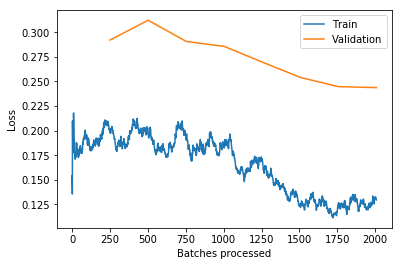

In [50]:
learn.recorder.plot_losses()

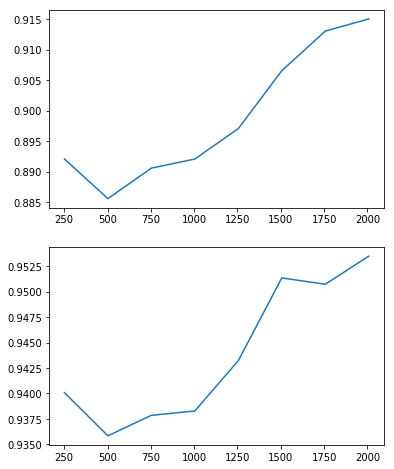

In [51]:
learn.recorder.plot_metrics()

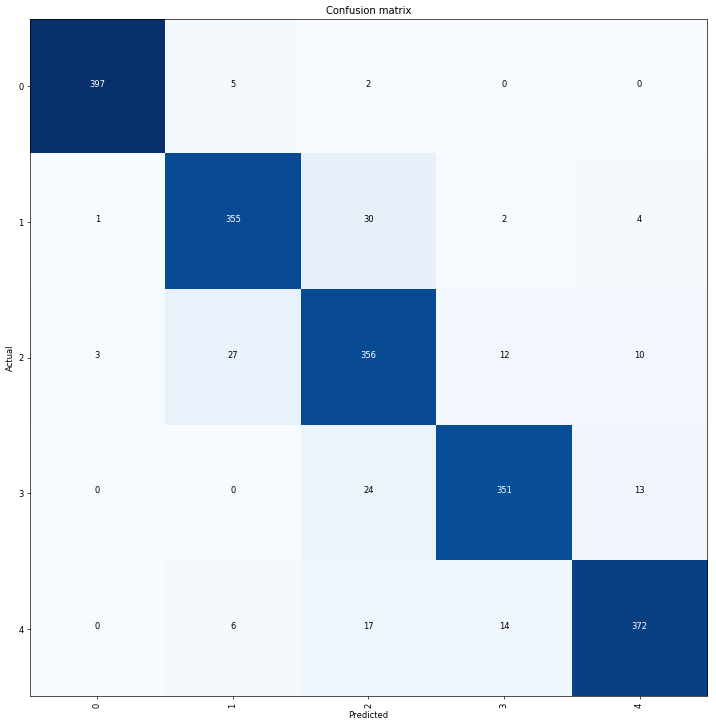

In [52]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [53]:
learn.save('stage-2-448')